#                                             Mictotask 2

####  Produce a chart showing the distribution of time-to-close (using the corresponding field in the GrimoireLab enriched index for GitHub issues) for issues already closed, and opened during the last six months.

In [1]:
from datetime import datetime
from pprint import pprint
from elasticsearch_dsl import Search

import elasticsearch as ES
import subprocess
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#### Configuring Repository name, Organisation's name, elasticsearch url, indices name and github access token.


In [2]:
# Url for the git repo to analyze
org_name = "grimoirelab"
repo_name = "perceval"
#url at which Elasticsearch must be running
es_url = "http://localhost:9200"

# Directory for letting Perceval clone the git repo
raw_index = "github_raw"
enriched_index = "github"

# ElasticSearch instance (url)
es = ES.Elasticsearch([es_url])

#verification token to avoid problems regarding unauthenticated access to the GitHub API
token = '36b6d5dd8be1dfb2f45ae6b903b1f83263df8c86'

#### Running p2o.py to retrieve data from github repository, enriching it and uploading it to elasticsearch.

In [4]:
#This takes sometime 
subprocess.run(['p2o.py', '--enrich', '--index', raw_index,
      '--index-enrich', enriched_index, '-e', es_url,
      '--no_inc', '--debug', 'github', org_name , repo_name,
      '-t',  token, '--sleep-for-rate'])

CompletedProcess(args=['p2o.py', '--enrich', '--index', 'github_raw', '--index-enrich', 'github', '-e', 'http://localhost:9200', '--no_inc', '--debug', 'github', 'grimoirelab', 'perceval', '-t', '36b6d5dd8be1dfb2f45ae6b903b1f83263df8c86', '--sleep-for-rate'], returncode=0)

#### Analysing the enriched indices and storing the search result in a list .We'll output a single object so as to analyse different fields present.


In [6]:
response=es.search(index=enriched_index)
total_commits = (response['hits']['total'])
response = es.search(index=enriched_index, body={"size":total_commits})
t = []
for x in range(total_commits):
         t.append(response['hits']['hits'][x]['_source'])
pprint (t[0])

{'assignee_email': None,
 'assignee_geolocation': None,
 'assignee_location': None,
 'assignee_login': 'sduenas',
 'assignee_name': 'Santiago Dueñas',
 'assignee_org': None,
 'author_name': 'Alvaro del Castillo',
 'closed_at': '2016-01-04T01:32:26Z',
 'created_at': '2015-12-04T17:48:34Z',
 'github_repo': 'chaoss/grimoirelab-perceval',
 'grimoire_creation_date': '2015-12-04T17:48:34+00:00',
 'id': 120451821,
 'id_in_repo': '2',
 'is_github_issue': 1,
 'item_type': 'pull request',
 'labels': '',
 'metadata__enriched_on': '2018-03-04T17:13:09.874694',
 'metadata__gelk_backend_name': 'GitHubEnrich',
 'metadata__gelk_version': '0.30.23',
 'metadata__timestamp': '2018-03-04T01:36:36.425836+00:00',
 'metadata__updated_on': '2016-01-21T14:01:54+00:00',
 'offset': None,
 'origin': 'https://github.com/grimoirelab/perceval',
 'pull_request': True,
 'repository': 'https://github.com/chaoss/grimoirelab-perceval',
 'state': 'closed',
 'tag': 'https://github.com/grimoirelab/perceval',
 'time_open_day

#### ElasticSearch_dsl for quering enriched indices. Sorting and filtering using elasticsearch_dsl inbuilt functions. And storing relevant fields in a dictionary. 
#### And if issue is still open specifying it.

In [8]:
request=Search(using=es ,index=enriched_index)
repo_data=[]

request = request.sort({'created_at':{'order':'desc'}})
request = request.filter("terms", item_type = ['issue'])
request = request.filter('range', created_at ={'gte': 'now-6M'})
request = request.source(['id', 'closed_at', 'created_at','time_open_days','time_to_close_days']) 
request = request[0:100]
s = request.execute()

for x in s :
    if(x.time_to_close_days == None):
        x.time_to_close_days = 'NA'
        x.closed_at = 'Issue still open'
    repo_data.append({'issue_id':x.id ,'time_open_days':x.time_open_days,'time_to_close_days':x.time_to_close_days,
                     'created_at':x.created_at,'closed_at':x.closed_at})
pprint ((repo_data[0])) 

{'closed_at': 'Issue still open',
 'created_at': '2018-03-02T18:22:45Z',
 'issue_id': 301859388,
 'time_open_days': 1.95,
 'time_to_close_days': 'NA'}


#### Producing dataframe of the stored data using pandas. And visualizing 10 features in form of a table.

In [9]:
df = pd.DataFrame(repo_data, columns=["issue_id","time_open_days","time_to_close_days","created_at","closed_at"])
df.head(10)

,issue_id,time_open_days,time_to_close_days,created_at,closed_at
0,301859388,1.95,NA,2018-03-02T18:22:45Z,Issue still open
1,301338299,3.31,NA,2018-03-01T09:45:12Z,Issue still open
2,298853432,11.46,NA,2018-02-21T06:13:04Z,Issue still open
3,298235932,0.53,0.53,2018-02-19T11:03:51Z,2018-02-19T23:48:50Z
4,297990762,2.05,2.05,2018-02-17T08:56:30Z,2018-02-19T10:02:53Z
5,297364923,17.36,NA,2018-02-15T08:37:18Z,Issue still open
6,297018141,18.34,NA,2018-02-14T08:57:59Z,Issue still open
7,295929758,23.03,NA,2018-02-09T16:29:36Z,Issue still open
8,295910162,23.07,NA,2018-02-09T15:33:40Z,Issue still open
9,291892484,3.14,3.14,2018-01-26T12:51:35Z,2018-01-29T16:15:00Z


#### Ploting bar chart using matplotlib.

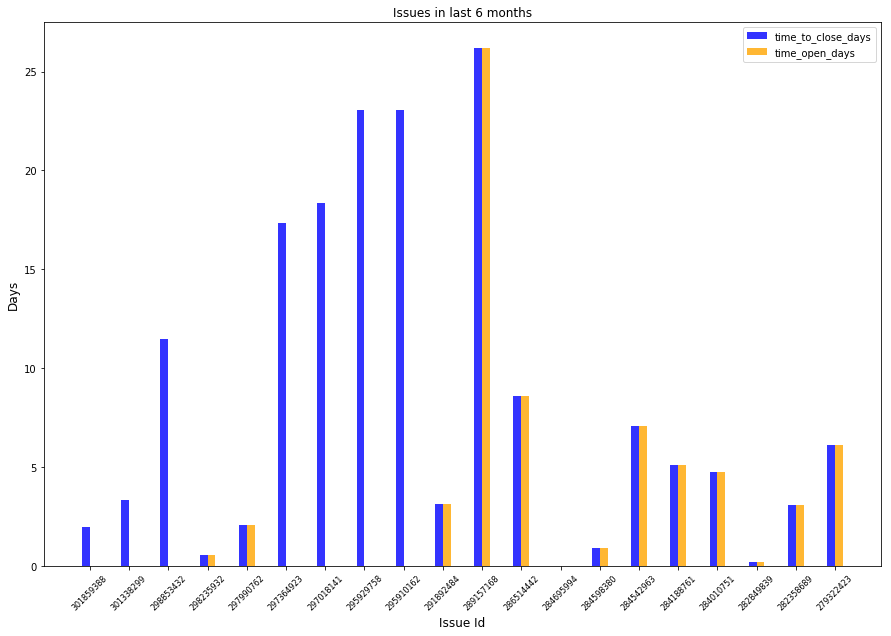

In [10]:
import numpy as np

# data to plot
n = 20
ids=[]
close_days=[]
open_days=[]
for x in range(n):
    ids.append(repo_data[x]['issue_id'])
    if(repo_data[x]['time_to_close_days']=='NA'):
        repo_data[x]['time_to_close_days']=0
    close_days.append(repo_data[x]['time_open_days'])
    open_days.append(repo_data[x]['time_to_close_days'])

 
# create plot
fig=plt.figure(figsize=(15,10))

index = np.arange(n)
bar_width = 0.2
opacity = 0.8
rects1 = plt.bar(index+ bar_width/2 , close_days, bar_width,
                 alpha=opacity,
                 color='blue',
                 label='time_to_close_days')
 
rects2 = plt.bar(index + bar_width +bar_width/2 , open_days, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='time_open_days')
plt.xlabel('Issue Id',fontsize=12)
plt.ylabel('Days',fontsize=12)
plt.title('Issues in last 6 months',fontsize=12)
plt.xticks(index + bar_width, ids,fontsize=8,rotation=45)
plt.legend()

plt.show()